In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Paper for this data set:
#https://www.techscience.com/cmc/v69n3/44131/html

df = pd.read_excel('gestationalDiabetes.xlsx', index_col = 0)

In [3]:
df.head()

,Age,No of Pregnancy,Gestation in previous Pregnancy,BMI,HDL,Family History,unexplained prenetal loss,Large Child or Birth Default,PCOS,Sys BP,Dia BP,OGTT,Hemoglobin,Sedentary Lifestyle,Prediabetes,Class Label(GDM /Non GDM)
Case Number,,,,,,,,,,,,,,,,
1,22,2,1,NaN,55.0,0,0,0,0,102.0,69,NaN,12.0,0,0,0
2,26,2,1,NaN,53.0,0,0,0,0,101.0,63,NaN,12.4,0,0,0
3,29,1,0,NaN,50.0,0,0,0,0,118.0,79,NaN,14.3,0,0,0
4,28,2,1,NaN,51.0,0,0,0,0,99.0,70,NaN,15.0,0,0,0
5,21,2,1,NaN,52.0,0,0,0,0,116.0,65,NaN,15.0,0,0,0


In [4]:
GDB = 'Class Label(GDM /Non GDM)'
df[GDB].value_counts()

0    2153
1    1372
Name: Class Label(GDM /Non GDM), dtype: int64

Reasonably balanced.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3525 entries, 1 to 3525
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              3525 non-null   int64  
 1   No of Pregnancy                  3525 non-null   int64  
 2   Gestation in previous Pregnancy  3525 non-null   int64  
 3   BMI                              2444 non-null   float64
 4   HDL                              2524 non-null   float64
 5   Family History                   3525 non-null   int64  
 6   unexplained prenetal loss        3525 non-null   int64  
 7   Large Child or Birth Default     3525 non-null   int64  
 8   PCOS                             3525 non-null   int64  
 9   Sys BP                           1820 non-null   float64
 10  Dia BP                           3525 non-null   int64  
 11  OGTT                             3012 non-null   float64
 12  Hemoglobin          

BMI, Sys BP, HDL, and OGTT have NaN. Our goal is to consider things that can be measured in an annual physical, so we will deal with BMI, Sys BP, and HDL. Before we handle the NaN, let's look at the distribution of the variables.

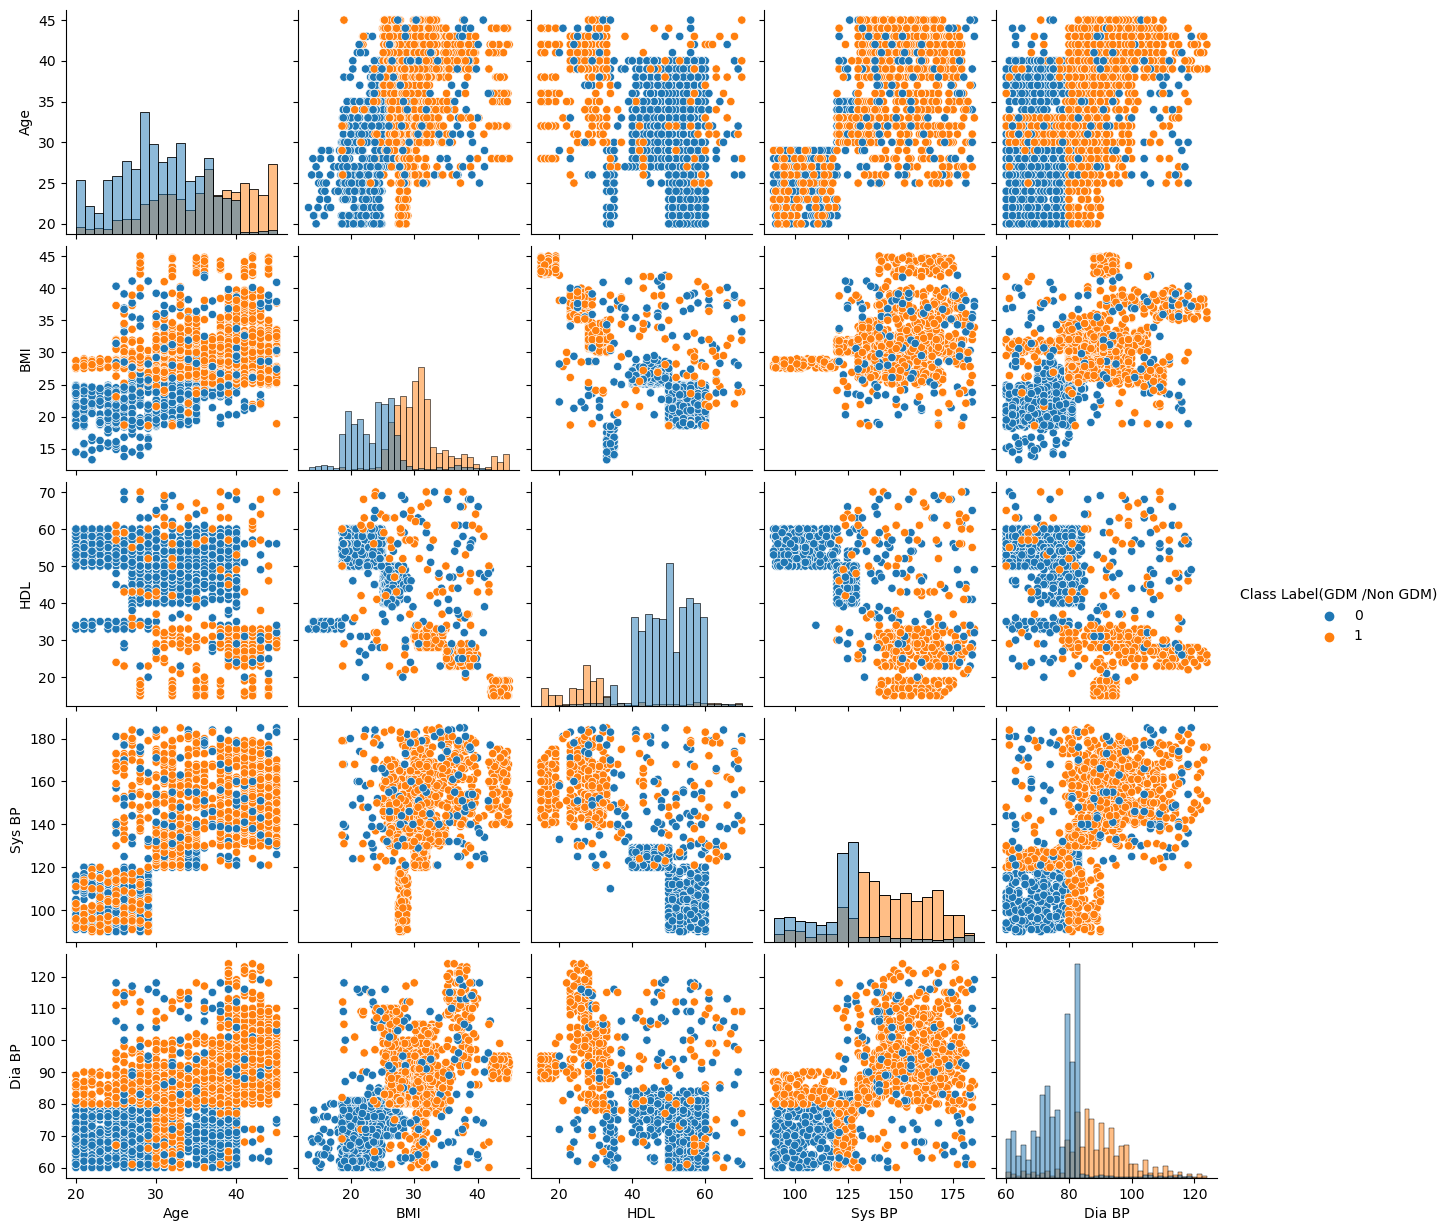

In [6]:
quant = ['Age','BMI','HDL','Sys BP', 'Dia BP']
sns.pairplot(df, hue = GDB, x_vars = quant, y_vars = quant, diag_kind = 'hist')

Every variable looks to have importance.

Let's look at Prediabetes, which can be diagnosed based fasting blood sugar and Hemoglobin A1C, which are both often measured at an annual physical.

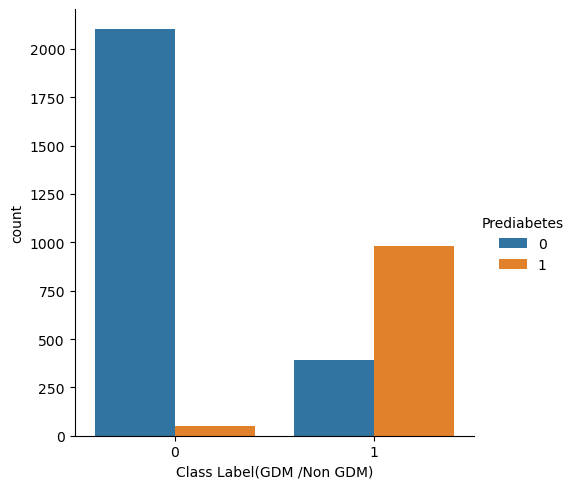

In [17]:
sns.catplot(data = df, hue = 'Prediabetes', x = GDB, kind = 'count')

This graph shows Prediabetes is highly specific and somewhat sensitive for Gestational Diabetes, so it will certainly be good to include it.

To fill in Nan, we will use mean to fill in HDL and BMI, and we will use
a regression fit to fill in the Sys BP based on the Dia BP.

In [14]:
#HDL and BMI
HDL_mean = np.mean(df['HDL'])
BMI_mean = np.mean(df['BMI'])
df['HDL'].fillna(HDL_mean, inplace = True)
df['BMI'].fillna(BMI_mean, inplace = True)

In [15]:
#Sys BP
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
bp = df[['Sys BP','Dia BP']].dropna()
reg.fit(bp[['Dia BP']], bp[['Sys BP']])
predicted_bp = reg.predict(df[['Dia BP']])
#need to flatten so that fillna can handle it
predicted_bp = [x[0] for x in predicted_bp]
df['Sys BP'] = df['Sys BP'].fillna(pd.Series(predicted_bp))

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3525 entries, 1 to 3525
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              3525 non-null   int64  
 1   No of Pregnancy                  3525 non-null   int64  
 2   Gestation in previous Pregnancy  3525 non-null   int64  
 3   BMI                              3525 non-null   float64
 4   HDL                              3525 non-null   float64
 5   Family History                   3525 non-null   int64  
 6   unexplained prenetal loss        3525 non-null   int64  
 7   Large Child or Birth Default     3525 non-null   int64  
 8   PCOS                             3525 non-null   int64  
 9   Sys BP                           3525 non-null   float64
 10  Dia BP                           3525 non-null   int64  
 11  OGTT                             3012 non-null   float64
 12  Hemoglobin          

Now to train our models.

In [17]:
df_physical = df[['Dia BP',
                            'Sys BP',
                            'HDL',
                           'BMI', 
                            'Age',
                            'Prediabetes',
                            GDB]]

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
X = df_physical[['Dia BP','Sys BP','HDL','BMI', 'Age','Prediabetes']]
y = df_physical[['Class Label(GDM /Non GDM)']]
X_train, X_test, y_train, y_test  = train_test_split(X,y)

Let's make some general code to test different models and features.

In [20]:
from sklearn.preprocessing import normalize
def model_test(model,normalized = True):
    """Train the given model on the used
    columns, print classification report and confusion matrix. Returns the model."""
    
    if normalized:
        model.fit(normalize(X_train),y_train)
        predictions = model.predict(normalize(X_test))
    else:
        model.fit(X_train,y_train)
        predictions = model.predict(X_test)
        
    print(classification_report(y_test,predictions))
    print(confusion_matrix(y_test,predictions))
    
    return model
    

In [25]:
#models to test:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [26]:
#logistic regression
model_test(LogisticRegression(), normalized = False)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       543
           1       0.91      0.78      0.84       339

    accuracy                           0.89       882
   macro avg       0.89      0.86      0.88       882
weighted avg       0.89      0.89      0.88       882

[[518  25]
 [ 76 263]]


C:\Users\philw\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [29]:
#KNN
model_test(KNeighborsClassifier(n_neighbors = 6), normalized = True)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       543
           1       0.92      0.89      0.90       339

    accuracy                           0.93       882
   macro avg       0.93      0.92      0.92       882
weighted avg       0.93      0.93      0.93       882

[[516  27]
 [ 37 302]]


C:\Users\philw\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\philw\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNeighborsClassifier(n_neighbors=6)

In [32]:
model_test(SVC())

C:\Users\philw\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.72      0.95      0.82       543
           1       0.83      0.42      0.56       339

    accuracy                           0.75       882
   macro avg       0.78      0.69      0.69       882
weighted avg       0.77      0.75      0.72       882

[[514  29]
 [195 144]]


SVC()

In [33]:
#Random Forest
model_test(RandomForestClassifier(),normalized = False)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       543
           1       0.94      0.97      0.96       339

    accuracy                           0.97       882
   macro avg       0.96      0.97      0.97       882
weighted avg       0.97      0.97      0.97       882

[[523  20]
 [  9 330]]


C:\Users\philw\AppData\Local\Temp\ipykernel_16584\1965559247.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


RandomForestClassifier()

Random forest seems to be great! We will use this one to build our webapp. If we give predictions as probabilities this can help people understand their risk of Gestational Diabetes given basic measurements from their annual physical.

In [34]:
model = model_test(RandomForestClassifier(),normalized = False)
probs = model.predict_proba(X)[:,1]
df_physical['Probability of Gestational Diabetes'] = probs

C:\Users\philw\AppData\Local\Temp\ipykernel_16584\1965559247.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       543
           1       0.95      0.98      0.96       339

    accuracy                           0.97       882
   macro avg       0.97      0.97      0.97       882
weighted avg       0.97      0.97      0.97       882

[[525  18]
 [  7 332]]


C:\Users\philw\AppData\Local\Temp\ipykernel_16584\2838156649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_physical['Probability of Gestational Diabetes'] = probs
